# 👌Get things prepare:
#### Preparing Tools and Libraries for Model Training

In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=cbf34fee79cd31c94275f2a90cc74cc31c7489c65190c39ca2df09e9351e35bf
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import pandas as pd
import torch
from numpy import arange
from datasets import load_dataset,Dataset, DatasetDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_metric
import nltk

In [3]:
import numpy as np
from transformers import (AutoTokenizer,
                          AutoModelForSeq2SeqLM,
                          AutoModelForSequenceClassification,
                          DataCollatorForSeq2Seq,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer)

2024-05-02 04:20:52.116290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 04:20:52.116407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 04:20:52.247066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#load model checkpoint of mT5 model
model_name = "google/mt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/kaggle/usr/lib/pip_install_lib/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Preprocess the data for the model input:
#### We will need to review the dataset that was previously used to train the model. Then convert our dataset to that input dataset. The dataset will focus solely on the Vietnamese language, since this is the language of interest, as this is our primary focus.

In [6]:
#here is our dataset
df = pd.read_csv("/kaggle/input/output-usefortrain/train_mt5_5k_rework.csv",usecols=["doc_content","summarize_content"]) 
df = df.astype(str)

In [7]:
def clean_it(text):
    s = str(text).replace("\n"," ").replace(',', ', ').replace('"', '').replace('\'', '\' ').replace("“","")\
.replace('(', '(').replace(')', ') ').replace('!', ' ! ')\
.replace('?',' ? ').replace(':',' ').replace(';',' ')\
.replace(' .',". ").replace(' . ',". ").replace('  ', ' ').replace('-', '')
    return s
    
df['doc_content'] =df['doc_content'].apply(lambda x: clean_it(x))
df['summarize_content'] = df['summarize_content'].apply(lambda x: clean_it(x))

In [8]:
# print("Text:",df['doc_content'][3])
# print("\nSummarize:",df['summarize_content'][3])

In [9]:
train_size = 0.9
def preprocess_function(examples):
    model_inputs = tokenizer(examples["doc_content"], max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summarize_content"], max_length=128, truncation=True)

    return {
        'input_ids' : model_inputs['input_ids'],
        'attention_mask': model_inputs['attention_mask'],
        'labels': labels['input_ids']
    }

def data_preprocessing(data, train_s):
    df_train, df_val = train_test_split(df,test_size = 1.0-train_s)
    print(f"Data split into: {round((len(df_train)/len(df))*100)}% train (with {len(df_train)} data)\t"
      f"{round((len(df_val)/len(df))*100)}% train (with {len(df_val)} data)")
    
    ds_train = Dataset.from_pandas(df_train)
    ds_val = Dataset.from_pandas(df_val)
    ds_dict = DatasetDict({'train' : ds_train,
              "valid":ds_val})
    return ds_dict

ds_dict = data_preprocessing(df,train_size)
tokenized_ds = ds_dict.map(preprocess_function,remove_columns=['__index_level_0__','doc_content', 'summarize_content'],batched=True,batch_size = 128)

Data split into: 90% train (with 5265 data)	10% train (with 586 data)


  0%|          | 0/42 [00:00<?, ?ba/s]

/kaggle/usr/lib/pip_install_lib/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?ba/s]

In [10]:
print("Our dataset before preprocessing:\n",ds_dict)
print("\nOur dataset after preprocessing:\n",tokenized_ds)

Our dataset before preprocessing:
 DatasetDict({
    train: Dataset({
        features: ['doc_content', 'summarize_content', '__index_level_0__'],
        num_rows: 5265
    })
    valid: Dataset({
        features: ['doc_content', 'summarize_content', '__index_level_0__'],
        num_rows: 586
    })
})

Our dataset after preprocessing:
 DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5265
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 586
    })
})


In [11]:
# sample = tokenized_ds["train"][10]

# # Printing its features
# print("input_ids:")
# print(sample['input_ids'])
# print("\n")
# print("attention_mask:")
# print(sample['attention_mask'])
# print("\n")
# print("labels:")
# print(sample['labels'])
# print("\n")

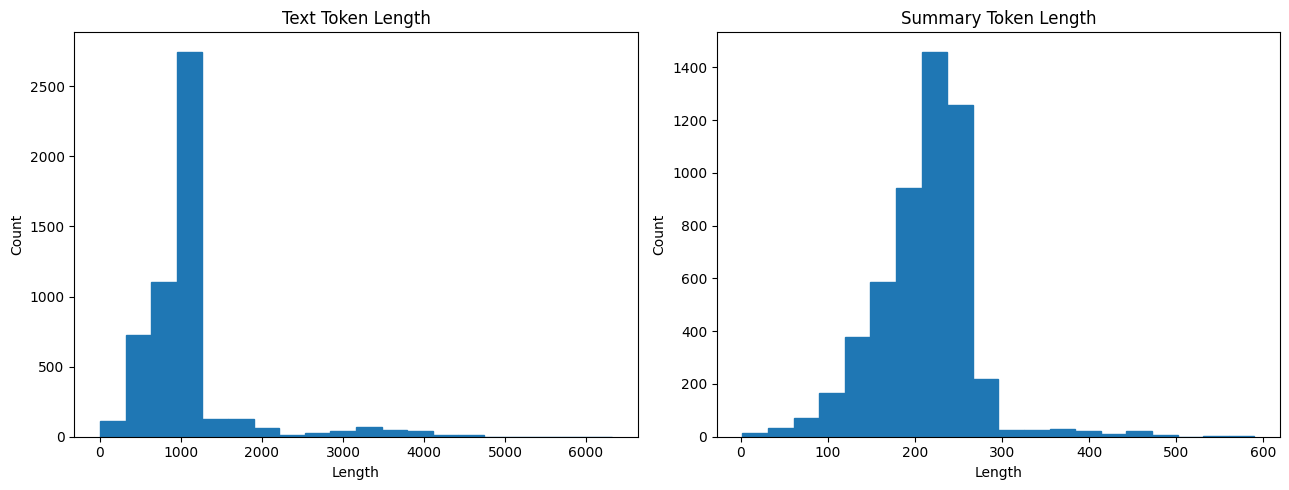

In [12]:
d_len = [len(tokenizer.encode(s)) for s in ds_dict["train"]["doc_content"]]
s_len = [len(tokenizer.encode(s)) for s in ds_dict["train"]["summarize_content"]]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))#, sharey=True)

axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Text Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [13]:
rouge_metric = load_metric('rouge')
bertscore = load_metric("bertscore")
# def compute_metrics1(eval_pred):
#     predictions, labels = eval_pred# Obtaining predictions and true labels
    
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
#     decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
#     decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
#     result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
#     result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
#     bertscore_result = score(decoded_preds, decoded_labels, lang='vi', verbose=True)

#     # Extract the precision, recall, and F1 scores
#     P, R, F1 = bertscore_result

#     # Convert tensors to lists
#     P = P.tolist()
#     R = R.tolist()
#     F1 = F1.tolist()
#     result['bertscore_precision'] = P
#     result['bertscore_recall'] = R
#     result['bertscore_f1'] = F1
#     return result

def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels
    
    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    
    # Computing rouge score
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()} # Extracting some results

    return {k: '{:.4f}'.format(v) for k, v in result.items()}

In [14]:
import gc
import torch

# Assuming `obj` is the object consuming GPU memory
obj = None

# Collect garbage'
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()

In [15]:
batch_size = 16
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./result",
    evaluation_strategy="epoch",
    logging_strategy = "epoch",
    save_strategy="epoch",
    
    #reduce memmory
    seed=42,
    optim="adafactor",
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    predict_with_generate=True,
    report_to = "none",
    
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate= 1e-5,
    lr_scheduler_type = "linear",
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=30,
)

# Defining Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Training
trainer.train()

/kaggle/usr/lib/pip_install_lib/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
0,13.213100,6.398167,9.3804,3.3234,8.6305,8.8526
1,10.482600,5.411167,9.4556,3.4044,8.6933,8.9027
2,9.575200,4.637005,9.6855,3.4825,8.8575,9.0818
3,7.878900,3.853258,10.3119,3.6778,9.4001,9.6183
4,6.703800,3.241660,10.6540,3.9099,9.7340,9.9699
5,6.064700,2.743876,11.4821,4.1765,10.3092,10.7546
6,5.112700,2.327523,12.0188,4.3778,10.7508,11.2700
8,4.403100,1.755872,13.0496,4.7590,11.5644,12.0911
9,3.745100,1.531544,14.3523,5.2884,12.4286,13.3260
10,3.523600,1.359888,15.2202,5.7701,13.0525,14.0538


/kaggle/usr/lib/pip_install_lib/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/kaggle/usr/lib/pip_install_lib/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/kaggle/usr/lib/pip_install_lib/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/kagg

TrainOutput(global_step=600, training_loss=3.617572181622187, metrics={'train_runtime': 41178.7215, 'train_samples_per_second': 3.836, 'train_steps_per_second': 0.015, 'total_flos': 3.672963496429793e+17, 'train_loss': 3.617572181622187, 'epoch': 29.09})

In [16]:
trainer.save_model("/kaggle/working/LBTopicSum_test")

In [17]:
import pandas as pd
history = pd.DataFrame(trainer.state.log_history)
history.to_csv("training_history.csv",index=False)
display(history)
loss_val = history['loss'].dropna().values.tolist()
eval_loss_val = history['eval_loss'].dropna().values.tolist()
rouge1 = history['eval_rouge1'].dropna().values.tolist()
rouge2 = history['eval_rouge2'].dropna().values.tolist()
rougeL = history['eval_rougeL'].dropna().values.tolist()
rougeLsum = history['eval_rougeLsum'].dropna().values.tolist()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,eval_rougeLsum,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,13.2131,7378.781250,9.666667e-06,0.97,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.97,20,6.398167,9.3804,3.3234,8.6305,8.8526,88.3829,6.630,0.419,NaN,NaN,NaN,NaN,NaN
2,10.4826,3556.797607,9.316667e-06,1.99,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.99,41,5.411167,9.4556,3.4044,8.6933,8.9027,84.9182,6.901,0.436,NaN,NaN,NaN,NaN,NaN
4,9.5752,3934.379150,8.983333e-06,2.96,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1.2718,1.098856,3.333333e-08,28.99,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,28.99,598,0.924482,19.9260,8.4616,16.4068,17.7956,86.2037,6.798,0.429,NaN,NaN,NaN,NaN,NaN
58,1.2039,1.040849,0.000000e+00,29.09,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,29.09,600,0.924454,19.9260,8.4616,16.4068,17.7956,86.3356,6.787,0.429,NaN,NaN,NaN,NaN,NaN


In [18]:
print(len(loss_val))
len(eval_loss_val)

30


30

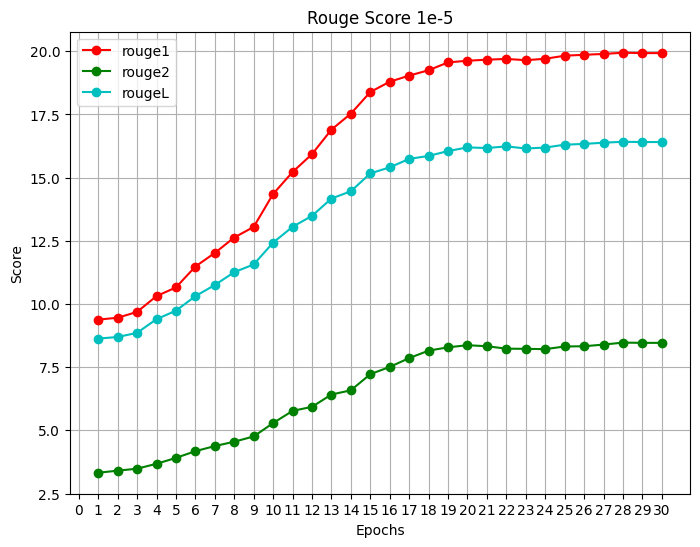

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rouge1) + 1), [float(score) for score in rouge1], marker='o', linestyle='-', color='red',label='rouge1')
plt.plot(range(1, len(rouge2) + 1), [float(score) for score in rouge2], marker='o', linestyle='-', color='green',label='rouge2')
plt.plot(range(1, len(rougeL) + 1), [float(score) for score in rougeL], marker='o', linestyle='-', color='c',label='rougeL')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.xticks(arange(0, len(loss_val)+1, 1))
plt.title('Rouge Score 1e-5')
plt.grid(True)
plt.legend()
plt.show()

[6.398167133331299, 5.411167144775391, 4.637004852294922, 3.853257894515991, 3.2416603565216064, 2.743875741958618, 2.3275232315063477, 2.0223731994628906, 1.7558720111846924, 1.5315438508987427, 1.3598878383636475, 1.2661386728286743, 1.168800711631775, 1.1222240924835205, 1.091131329536438, 1.0655313730239868, 1.039948582649231, 1.0189248323440552, 1.0042650699615479, 0.9845523238182068, 0.9683430790901184, 0.9604467153549194, 0.9515325427055359, 0.941510796546936, 0.9351791143417358, 0.9309102892875671, 0.9276197552680969, 0.9255197644233704, 0.9244815707206726, 0.9244541525840759]


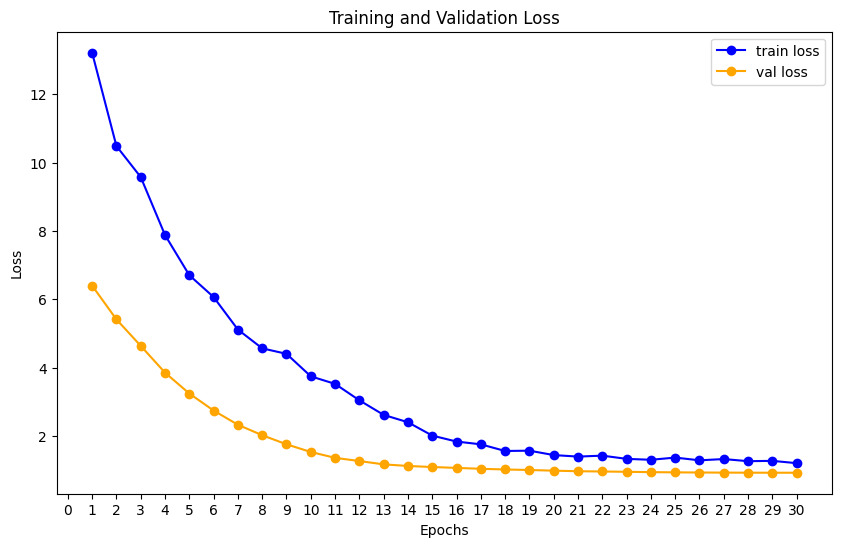

In [20]:
print(eval_loss_val)
from numpy import arange
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_val)+1), loss_val, marker='o', linestyle='-', color='blue',label='train loss')
plt.plot(range(1, len(eval_loss_val)+1), eval_loss_val, marker='o', linestyle='-', color='orange',label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(arange(0, len(loss_val)+1, 1))
# plt.yticks(arange(0, max(loss_val)))
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
from transformers import pipeline
model_path = "./LBTopicSum_test"
gen_kwargs = {"length_penalty": 0.8, "num_beams":15, "max_length": 128,  "no_repeat_ngram_size": 2}
summarizer = pipeline("summarization", model=model_path, tokenizer = model_path)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/kaggle/usr/lib/pip_install_lib/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [22]:
review = ds_dict["train"][0]["doc_content"]
ref = ds_dict["train"][0]["summarize_content"]
summary = summarizer(ds_dict["train"][0]["doc_content"], **gen_kwargs)[0]["summary_text"]
print(f"'>>>Review: {review}'")
print(f"\n'>>> Reference Summary: {ref}'")
print(f"\n'>>> Predicted Summary: {summary}'")

'>>>Review: Nơi đây nổi tiếng với các món ăn mang đậm hương vị núi rừng như lợn bản gà đồi cá suối Trong đó đặc biệt nhất phải nói đến chân giò chiên. Đây chính là mà ăn làm nên cái riêng của nhà hàng được rất nhiều thực khách khi du lịch Tam Đảo yêu thích. Nhà hàng Phố Núi Địa chỉ Xã Hợp Châu Tam Đảo Vĩnh Phúc gần cổng UBND xã. Số điện thoại 0916 241 666 Xem thêm Top những homestay cực chill tại Tam Đảo khiến bạn phải đóng băng vì đẹp mê hồn 4 – Nhà hàng Không Gian Quán Không Gian Quán là một trong những quán ăn ngon nhất Tam Đảo nằm ở lưng chừng đồi đường dẫn xuống Thác Bạc nên thơ hùng vỹ. Món ăn nổi tiếng nhất tại đây chính là gà nướng giấy bạc tươi ngon nóng hổi. Gà được tẩm ướp theo bí quyết riêng của nhà hàng nên hương vị vô cùng đặc biệt. Ngoài ra đến với Không Gian Quán bạn còn có thể thưởng thức nhiều món ăn hấp dẫn khác như trứng nướng thịt nướng thịt sóc dúi rừng Tất cả đều được đánh giá là có mức giá khá rẻ. Nhà hàng Không Gian Quán nổi tiếng với món gà nướng. vn ĐỊa chỉ T

In [23]:
# from transformers import pipeline

# model_path = "/kaggle/input/lbtopicsum/pytorch/lbtopicsum/1"
# tokenizer = AutoTokenizer.from_pretrained(model_path)  
# model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [24]:
# num=1
# review = df_test["doc_content"][num]
# ref = df_test["summarize_content"][num]
# summary = summarizer(df_test["doc_content"][num], max_length=128)[0]["summary_text"]
# print(f"'>>>Review: {review}'")
# print(f"\n'>>> Reference Summary: {ref}'")
# print(f"\n'>>> Predicted Summary: {summary}'")

In [25]:
# df_test = pd.read_csv("/kaggle/input/output-usefortrain/test_mt5.csv",usecols=["doc_content","summarize_content"]) 
# df_test = df_test.astype(str)  
# df_test

In [26]:
# num=2
# text = df_test["doc_content"][num]
# encoding = tokenizer(text, )
# input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]

# outputs = model.generate(
#     input_ids=input_ids, attention_mask=attention_masks,
#     max_length=128,
#     early_stopping=True
# )
# for output in outputs:
#     line = tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
#     print(line)

In [27]:
# import dill
# save
# dill.dump_session('/kaggle/working/train_state.db')

# load
# dill.load_session('/kaggle/working/train_state.db')

In [28]:
# import shutil
# shutil.rmtree("/kaggle/working/")
# import os
# os.remove("/kaggle/working/state.db")

In [29]:
# history56 = pd.read_csv("/kaggle/input/test-history/training_history5.6.csv")
# loss_val_0, eval_loss_val_0, rouge1_0, rouge2_0, rougeL_0, rougeLsum_0 = [history56[key].dropna().values.tolist() for key in ['loss', 'eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']]

# history6 = pd.read_csv("/kaggle/input/test-history/training_history6.csv")
# loss_val_1, eval_loss_val_1, rouge1_1, rouge2_1, rougeL_1, rougeLsum_1 = [history6[key].dropna().values.tolist() for key in ['loss', 'eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']]

# history7 = pd.read_csv("/kaggle/input/test-history/training_history7.csv")
# loss_val_2, eval_loss_val_2, rouge1_2, rouge2_2, rougeL_2, rougeLsum_2 = [history7[key].dropna().values.tolist() for key in ['loss', 'eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']]

# history8 = pd.read_csv("/kaggle/input/test-history/training_history7.csv")
# loss_val_3, eval_loss_val_3, rouge1_3, rouge2_3, rougeL_3, rougeLsum_3 = [history8[key].dropna().values.tolist() for key in ['loss', 'eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']]

In [30]:
# fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(15, 10))
# for i in range(2):
#     for j in range(2):
#         if ax[i][j] == ax[0][0]: 
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_0, eval_loss_val_0, rouge1_0, rouge2_0, rougeL_0, rougeLsum_0
#             ax[i][j].set_title('Rouge Score lr=5.6e-4')
#         elif ax[i][j] == ax[0][1]: 
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_1, eval_loss_val_1, rouge1_1, rouge2_1, rougeL_1, rougeLsum_1 
#             ax[i][j].set_title('Rouge Score lr=6e-4')
#         elif ax[i][j] == ax[1][0]:
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_2, eval_loss_val_2, rouge1_2, rouge2_2, rougeL_2, rougeLsum_2
#             ax[i][j].set_title('Rouge Score lr=7e-4')
#         elif ax[i][j] == ax[1][1]:
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_3, eval_loss_val_3, rouge1_3, rouge2_3, rougeL_3, rougeLsum_3
#             ax[i][j].set_title('Rouge Score lr=8e-4')
#         ax[i][j].plot(range(1, len(rouge1) + 1), [float(score) for score in rouge1], marker='o', linestyle='-', color='red',label='rouge1')
#         ax[i][j].plot(range(1, len(rouge2) + 1), [float(score) for score in rouge2], marker='o', linestyle='-', color='green',label='rouge2')
#         ax[i][j].plot(range(1, len(rougeL) + 1), [float(score) for score in rougeL], marker='o', linestyle='-', color='c',label='rougeL')
#         ax[i][j].set_xlabel('Epochs')
#         ax[i][j].set_ylabel('Score')
#         ax[i][j].set_xticks(arange(0, len(loss_val)+1, 1))
#         ax[i][j].grid(True)
#         ax[i][j].legend()

In [31]:
# print("3 last epoch rougeL (lr=5.6e-4):",rougeL_0[-3:])
# print("3 last epoch rougeL (lr=6e-4):\t",rougeL_1[-3:])
# print("3 last epoch rougeL (lr=7e-4):\t",rougeL_2[-3:])
# print("3 last epoch rougeL (lr=8e-4):\t",rougeL_3[-3:])

In [32]:
# fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(15, 10))
# for i in range(2):
#     for j in range(2):
#         if ax[i][j] == ax[0][0]: 
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_0, eval_loss_val_0, rouge1_0, rouge2_0, rougeL_0, rougeLsum_0
#             ax[i][j].set_title('Training and Validation Loss lr=5.6e-4')
#         elif ax[i][j] == ax[0][1]: 
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_1, eval_loss_val_1, rouge1_1, rouge2_1, rougeL_1, rougeLsum_1 
#             ax[i][j].set_title('Training and Validation Loss lr=6e-4')
#         elif ax[i][j] == ax[1][0]:
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_2, eval_loss_val_2, rouge1_2, rouge2_2, rougeL_2, rougeLsum_2
#             ax[i][j].set_title('Training and Validation Loss lr=7e-4')
#         elif ax[i][j] == ax[1][1]:
#             loss_val, eval_loss_val, rouge1, rouge2, rougeL, rougeLsum = loss_val_3, eval_loss_val_3, rouge1_3, rouge2_3, rougeL_3, rougeLsum_3
#             ax[i][j].set_title('Training and Validation Loss lr=8e-4')
#         ax[i][j].plot(range(1, len(loss_val)+1), loss_val, marker='o', linestyle='-', color='blue',label='train loss')
#         ax[i][j].plot(range(1, len(eval_loss_val)+1), eval_loss_val, marker='o', linestyle='-', color='orange',label='val loss')
#         ax[i][j].set_xlabel('Epochs')
#         ax[i][j].set_ylabel('Loss')
#         ax[i][j].set_xticks(arange(0, len(loss_val)+1, 1))
#         ax[i][j].legend()

In [33]:
# print("3 last epoch loss (lr=5.6e-4):\t",loss_val_0[-3:])
# print("3 last epoch loss (lr=6e-4):\t",loss_val_1[-3:])
# print("3 last epoch loss (lr=7e-4):\t",loss_val_2[-3:])
# print("3 last epoch loss (lr=8e-4):\t",loss_val_3[-3:])